In [1]:
using Plots, Interact, DifferentialEquations, BifurcationKit, Setfield, ForwardDiff
using NonLinearDynamicsCourse

WebIO._IJuliaInit()

# Bifurcacion Saddle-Node en el plano y separacion de escalas temporales

Volvemos al sistema minimal con no linealidad cuadrática:

$\dot{x} = a-y$

$\dot{y} = x^2-y$

Donde se puede ver que lo que sucede a medida que $a$ se aproxima a cero por los positivos es que los dos puntos fijos (un punto silla y un atractor) se van acercando y para $a=0$ colapsan y se produce una bifurcacion de nodo-silla en el plano. 

El cambio del flujo debido a la bifurcacion es analogo a lo que observabamos en 1D, ya que la bifurcacion se produce a lo largo de una curva y en la direccion perpendicular a la curva el flujo es atractor. Esto se ve mas claro si le agregamos un parametro $b$ que permita amplificar la disipacion (obviamente positivo).

$\dot{x} = a-y$

$\dot{y} = x^2-by$

Cuando $b$ es muy grande como se puede probar en las celdas que siguen el flujo converge muy rapidamente a la nulclina de $\dot{y}=0$ y una vez sobre esa curva se mueve mas lentamente hacia el nodo atractor. Es decir que en este caso la dimension adicional entra como una variable rapida (un transitorio), pero la dinamica interesante sucede a lo largo de la curva (parabola) y sobre esa curva se produce la bifurcacion (explorarlo en el grafico interactivo debajo). 


In [2]:
function nodosilla2d!(du,u,p,t)
    (a,b) = p
    du[1] = a-u[2]
    du[2] = u[1]*u[1]-b*u[2]
    du
end    

nodosilla2d! (generic function with 1 method)

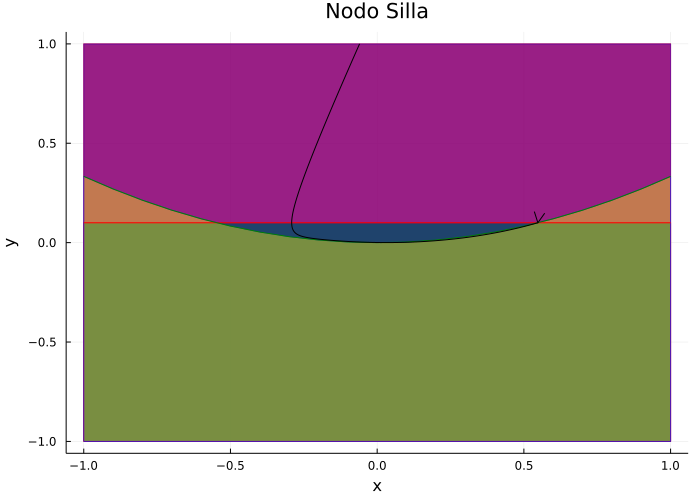

In [28]:
# Esto es interactivo en ipynb
#xini=-0.06;yini=1.0;a=0.1;b=3.0
@manipulate throttle=0.5 for xini=-1:0.01:1, yini=-1:0.1:1,a=0.0:0.01:0.2,b=1.0:0.1:5.0
    flux2d_nullclines(nodosilla2d!,[xini;yini],30.0,[a,b];title="Nodo Silla")
end    

Esta separación de escalas de tiempo, la misma que veíamos en los osciladores de relajación es muy importante ya que:
- muchos sistemas naturales (y artificiales) presentan esta separación de escalas de tiempo, cada dinámica tiene su propio tiempo característico
- nos permite separar el análisis del problema no lineal en dos etapas; una primera etapa donde el sistema relaja siguiendo una dirección de evolución rápida y podemos considerar a las otras direcciones lentas como parámetros, seguida de una evolución lenta sobre alguna variedad (en 2D una curva) donde en general ocurre la dinámica interesante
- las bifurcaciones ocurren siempre sobre las variedades "lentas", esto esta vinculado con el Critical Slowing Down, siempre cerca de una bifuracion la dinamica se enlentece, basicamente porque en las otras direcciones transversales a la variedad el flujo converge (o diverge) exponencialmente, pero sobre la variedad se mueve enlentecido por la proximidad de una bifurcación
- cuando se estudian sistemas de más dimensiones nos va a interesar lo que ocurre sobre las variedades lentas (o centrales)  y vamos a colapsar la dinámica a una evolución con menos grados de libertad (por lo general uno o dos) sobre esas variedades, proceso que se conoce como **reducción a la variedad central**
- la bifurcaciones ocurren variedades de muy baja dimension. La Saddle Node por ejemplo ocurre siempre en una variedad unidimensional, la Hopf que vamos a ver más adelante en una variedad bidimensional. Y luego aunque tengamos sistemas n-dimensionales la mayor parte de los cambios cualitativos que ocurren en el flujo se van a poder explicar por estas bifurcaciones que ocurren en 1D o 2D.

Si bien todo esto puede parecer al principio muy abstracto, es uno de los conceptos centrales junto con el de formas normales en el estudio cualitativo de los sistemas dinámicos.

Como ejemplo podemos ver en la evolucion de multiples trayectorias en el gráfico de abajo (para un valor grande de $b$) que la dinámica rápida colapsa a un entorno de la nulclina parabolica y luego sobre esa region evoluciona como un sistema 1D en un entorno de una bifurcacion nodo silla.

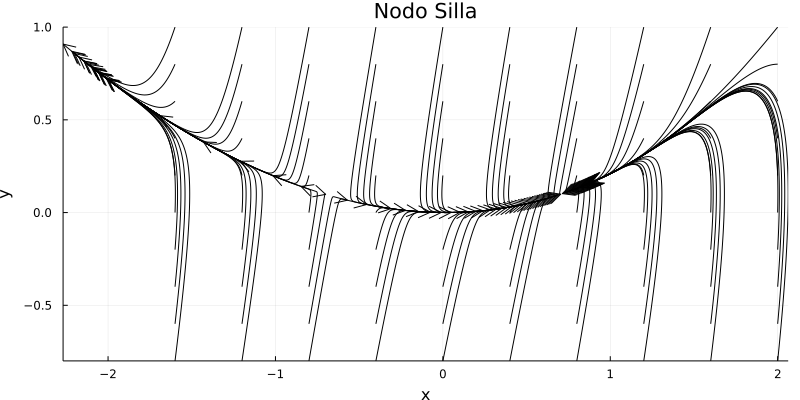

In [35]:
a = 0.1; b = 5.0
function prob_func(prob,i,repeat)
  remake(prob,u0=u0_arr[i])
end
condition(u,t,integrator) = (u[1]*u[1]+u[2]*u[2]) > 4.5
affect!(integrator) = terminate!(integrator)
u0_arr=[[-2+i*0.4;-1+j*0.2] for i=1:10 for j=1:10]
prob = EnsembleProblem(ODEProblem(nodosilla2d!,u0_arr[1],(5.0),[a,b]),prob_func=prob_func)
sol = solve(prob,callback=DiscreteCallback(condition,affect!),
    EnsembleThreads(),trajectories=length(u0_arr))
p1 = plot(sol,vars=(1,2),arrows=true;legend=false,xlabel="x",ylabel="y",c=:black,
    size=(800,400),title="Nodo Silla",fmt=:png)

Vamos a hacer un cambio de coordenadas que pone de evidencia que este sistema tiende a la bifurcacion SN sobre una recta  cuando $b$ es grande. 

$w = \displaystyle\frac{y-a}{b}-x$

$z = \displaystyle\frac{x}{\sqrt{b}}$

con la transformacion inversa:

$x= \sqrt{b}z$

$y=bw+b\sqrt{b}z+a$

El nuevo sistema queda escrito 

$\dot{w}=\displaystyle\frac{\dot{y}}{b} - \dot{x} = \displaystyle\frac{x^2-by}{b}+y-a = \displaystyle\frac{x^2}{b}-a = z^2-a$

$\dot{z}=\displaystyle\frac{\dot{x}}{\sqrt{b}} = \displaystyle\frac{1}{\sqrt{b}}(a-y) = \displaystyle\frac{1}{\sqrt{b}}(a-bw-b\sqrt{b}z-a) = -\sqrt{b}w-bz$

Pasando en limpio, nos queda un sistema donde el término cuadrático qeuda solo con el parámetro de bifurcación:

$\dot{w}= z^2-a$

$\dot{z}= -\sqrt{b}w-bz$

Como es un cambio lineal de coordenadas el sistema sigue teniendo dos puntos fijos para $a>0$ con la misma estabilidad. El punto fijo estable está en:

$w_* = \mp \sqrt{ab}$

$z_* = \pm \sqrt{a}$

El cambio lineal de coordenadas nos garantiza que el retrato de fases es topologicamente equivalente, pero la forma del flujo puede cambiar porque es un sistema no lineal y de hecho este cambio lo que hace es "rectificar" la parabola y ahora la nulclina de la segunda variable es la recta $z=-w/\sqrt{b}$ como puede verse en el diagrama de abajo

In [5]:
function nodosilla2da!(du,u,p,t)
    (a,b) = p
    du[1] = u[2]*u[2]-a
    du[2] = -sqrt(b)*u[1]-b*u[2]
    du
end    

nodosilla2da! (generic function with 1 method)

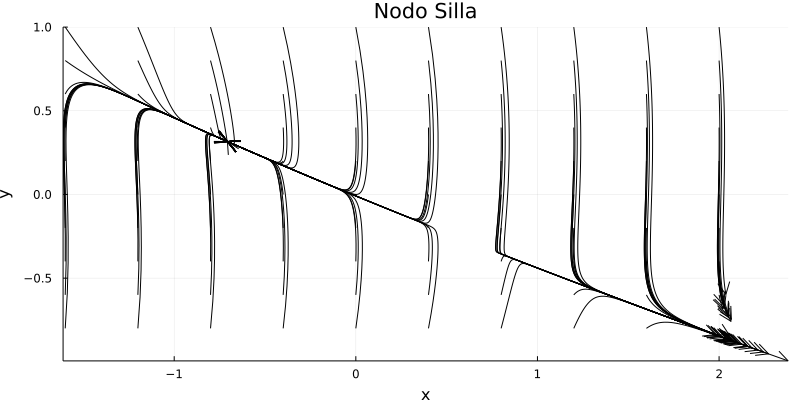

In [36]:
prob = EnsembleProblem(ODEProblem(nodosilla2da!,u0_arr[1],(30.0),[a,b]),prob_func=prob_func)
sol = solve(prob,callback=DiscreteCallback(condition,affect!),
    EnsembleThreads(),trajectories=length(u0_arr))
p1 = plot(sol,vars=(1,2),arrows=true;legend=false,xlabel="x",ylabel="y",c=:black,
    size=(800,400),title="Nodo Silla",fmt=:png)

En esta versión del sistema la variable $z$ es la variable "rapida" que converge impulsada por $-\sqrt{b}w-bz$ a la nulclina diagonal. Si bien no tenemos el sistema desacoplado una vez que estamos sobre esa nulclina, al igual que en el caso de los osciladores de relajación la ecuación que gobierna el flujo es la "lenta" , ya que en este caso podemos considerar sobre la recta $z=w/\sqrt{b}$ y reemplazar en la primer ecuación, escalear el tiempo con $(\tau=t/b)$ y el parametro de bifurcacion $\alpha=ab$,  con lo cual nos queda la forma normal 1D de la saddle node:

$\displaystyle\frac{dw}{dt} = z^2 - a = \displaystyle\frac{w^2}{b} - a$

$\displaystyle\frac{dw}{d(b\tau)} = \displaystyle\frac{w^2}{b} - \displaystyle\frac{\alpha}{b}$

$\displaystyle\frac{dw}{d\tau} = w^2 - \alpha$



Finalmente puede ser instructivo ver como se modifican las variedades estables del punto silla con el parametro $b$ en el sistema original. Recordar que estas curvas (en azul) actuan como separatrices del flujo, Todo lo que este del lado de estas curvas donde esta el atractor converje a el y todo lo que esta del otro se escapa. Si $b$ es chico las variedades se acercan al atractor y la region estable es muy chica. A medida que $b$ crece la variedad inestable (curva roja) sigue la parabola y la estable se transforma en una recta perpendicular a la parabola en ese punto, y todo lo que esta a la derecha queda en la cuenca de atraccion del punto fijo de la derecha 

In [7]:
function nodosilla2d_jac(u,p)
  J = Array{Float64, 2}(undef, 2, 2)
  J[1,1] = 0
  J[1,2] = -1.0
  J[2,1] = 2*u[1]
  J[2,2] = -p[2]
  return J
end

nodosilla2d_jac (generic function with 1 method)

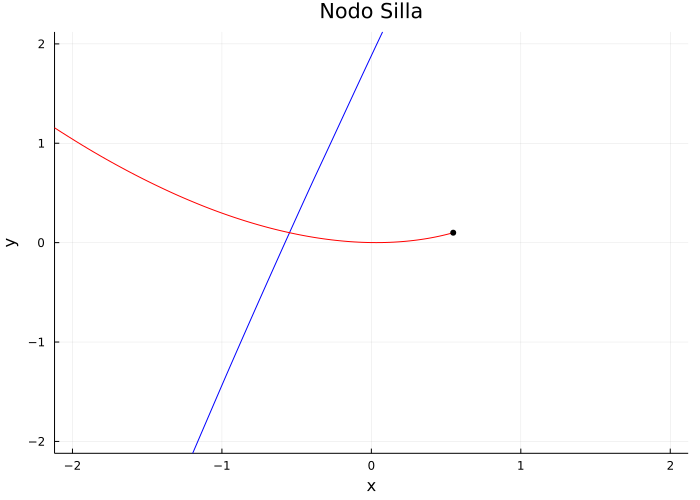

In [29]:
# Esto es interactivo en ipynb
#a=0.1;b=3.0
@manipulate for a=0.0:0.01:0.2,b=0.0:0.1:3.0
    u0_array=[[-sqrt(a*b);a],[sqrt(a*b);a]]
    flux2d_manifolds(nodosilla2d!,nodosilla2d_jac,u0_array,[a,b];
        tmax=300,delta=1e-7,xlims=[-2,2],ylims=[-2,2],title="Nodo Silla")
end    

La cuenca de atraccion del punto fijo estable es lo que queda del lado de la variedad estable del punto silla (curva azul) donde esta el punto fijo. Notar como afecta el parámetro $b$ la forma de la cuenca de atracción.

## Estabilidad de los puntos fijos y autovalores

Los puntos fijos para $a>0$ en el sistema original estan en ($x_*=\pm\sqrt{ab}$,$y_*=a$) y la matriz jacobiana evaluada en ese punto es:

$\begin{pmatrix}0 & -1\\\pm2\sqrt{ab} & -b\end{pmatrix}$

Que la traza sea siempre negativa ($-b$) implica que ninguno de ellos es un repulsor, solo puede ser un punto silla o un atractor. Esto es logico porque hay una direccion en la que los dos son atractores y es la direccion en la que converge rapidamente a la parabola. Mientras que el determinante es positivo para el punto a la derecha (atractor) y negativo para el de la izquierda (punto silla). 

$\Delta = 2\sqrt{ab}\quad$, para $x_*=\sqrt{ab}\quad$ (atractor)

$\Delta = -2\sqrt{ab}\quad$, para $x_*=-\sqrt{ab}\quad$ (punto silla)

A medida que nos acercamos a la bifurcacion ambos puntos tienen la misma traza y el determinante se va aproximado a cero por los negativos y los positivos y colisionan en el eje $\Delta=0$. 

Es interesante que en el sistema transformado $(w,z)$ si el flujo cambio y el jacobiano da diferente, el determinante y la traza y por ende sus autovalores son los mismos. 

En efecto, los puntos fijos ahora son $(x^*_1,y^*_1) = (-\sqrt{ab},\sqrt{a})$ y $(x^*_2,y^*_2) = (\sqrt{ab},-\sqrt{a})$. La matriz jacobiana de forma general es:

$\begin{pmatrix}0 & 2z\\-\sqrt{b} & -b\end{pmatrix}$

cuya traza es como antes $-b$ y su determinante es 

$\Delta = 2\sqrt{ab}\quad$, para $x^*_1\quad$ (atractor)

$\Delta = -2\sqrt{ab}\quad$, para $x^*_2\quad$ (punto silla)

Nota que la separación entre los puntos es la misma a pesar de que la transformación invirtió la orientación (en este caso el atractor está a la derecha.

Otra forma mas interesante de verlo es recordar que los autovalores de la matriz se podian escribir como 

$\lambda_1 = \frac{\tau+\sqrt{\tau^2-4\Delta}}{2} \quad \quad \lambda_2 = \frac{\tau-\sqrt{\tau^2-4\Delta}}{2}$ 

Para el atractor estos autovalores serian:

$\lambda_1 = \frac{-b+\sqrt{b^2-8\sqrt{ab}}}{2} \quad \quad \lambda_2 = \frac{-b-\sqrt{b^2-8\sqrt{ab}}}{2}$ 

Ambos autovalores son negativos (y reales porque recordemos que $b$ es un valor grande y estamos estudiando el imite de la bifurcacion de $a$ acercandose a cero desde los positivos) porque le estamos sumando y restando a $-b$ un numero que es mas chico en valor absoulto (la raiz es mas chica).

y para el punto silla:

$\lambda_1 = \frac{-b+\sqrt{b^2+8\sqrt{ab}}}{2} \quad \quad \lambda_2 = \frac{-b-\sqrt{b^2+8\sqrt{ab}}}{2}$ 

Ahora la raiz es mas grande que $b$ en valor absoluto asi que el primer autovalor es positivo y tiene asociado un autovector que apunta en la direccion repulsora del punto silla (se puede calcular que para $b$ grande es tangente a la parabola).

Lo interesante es que a medida que nos aproximamos a la bifurcacion el segundo autovalor tiende en ambos casos a $-b$, pero el primero tiende a cero (por los negativos y por los positivos) y en la bifurcacion es estrictamente cero. Esta condicion es necesaria en general para que ocurra la bifurcacion de nodo silla en cualquier numero de dimensiones. Podemos tener varias direcciones con autovalores diferentes de cero, pero si en una de las direcciones uno de los autovalores se hace cero (o mas estrictamente cruza el cero por el eje real para distinguirla de otras) entonces tenemos una bifurcacion de nodo silla. De un lado de la bifurcacion tendremos dos puntos fijos (con autovalores positivos y negativos en esa direccion) y del otro lado esos dos puntos fijos no existen mas. Hay algunas condiciones que se tienen que cumplir para distinguirla de la transcritica y la pitchfork (y de otras que se vana a ver mas adelante), pero por ahora nos vamos a quedar con esa condicion

### Deteccion de la Nodo Silla usando BifurcationKit

Vamos a usar BifurcationKit para barrer esta bifurcación. Como antes tenemos que definir una versión de la función "out of place" y sin dependencia temporal, eso lo hacemos en la primer linea.

Luego barremos de $-0.1$ a $0.2$ pero **hacia atras** porque tenemos que partir de un valor de $a$ positivo para detectar puntos fijos. Eso se indica con un valor de $ds$ negativo en las opciones de `ContinuationPar` (mientras que pMax pMin son los valores maximo y minimo y dsmax el maximo paso permitido). 

La funcion `continuation` recibe como argumentos obligatorios:
- la funcion del campo vector
- un "guess" para el punto fijo para el valor inicial de los parámetros. No es necesario que sea la posicion exacta del punto fijo sino un valor cercano para el método numérico.
- los valores iniciales de parametros (aca usamos $b=0$ y colocamos el primer valor de $a$ en pMax). 
- el argumento `@lens _[1]` indica que vamos a barrer el primer parámetro.
- las opciones de continuacuón que definimos anteriormente


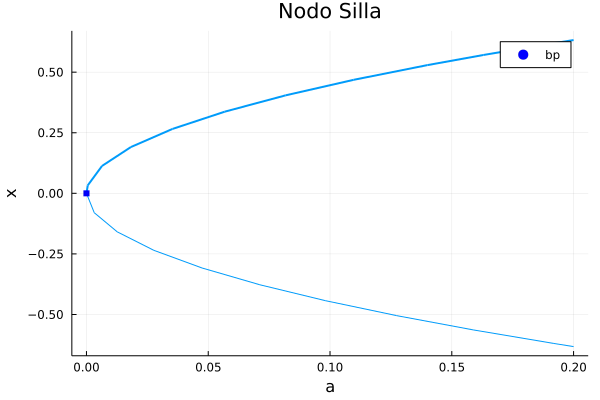

In [9]:
nodosilla2d(u,p) = nodosilla2d!(similar(u),u,p,0)
opts = ContinuationPar(pMin=-0.1,pMax=0.2, ds = -0.01, dsmax = 0.04,detectBifurcation=3,nInversion=8)
br1, = continuation(nodosilla2d,[0.1,0.1],[0.2,2.0],(@lens _[1]), opts;recordFromSolution = (x, p) -> x[1])
plot(br1,xlabel="a",title="Nodo Silla",fmt=:png)

# Bifurcacion Pitchfork en el plano

Vamos a volver al oscilador de Duffing con disipación:

$\dot{x} = y$

$\dot{y} = -\gamma y + \beta x -  x^3$

Con puntos fijos en:

Para $\beta<0$:
    
$x^*_1=0$ atractor

Para $\beta>0$:

$x^*_1=0$ punto silla

$x^*_{2,3} = \pm \sqrt{\beta}$ atractores

Cuando $\beta$ cruza el cero el punto fijo $x^*_1$ cambia de estabilidad de  (deja de ser atractor) y al mismo tiempo aparecen otros dos puntos fijos en posiciones simétricas. Esto es una bifurcacion de Pitchork. 

Pero notar que el cambio de estabilidad es de un nodo atractor a un punto silla (no un repulsor). Eso es porque hay una direccion (transversal a la parabola) que es siempre atractora, y ese punto fijo luego de la bifurcacion pasa a tener una direccion inestable (punto silla) y esa direccion inestable es en la direccion tangente a la parabola. 
Verificar eso en el grafico interactivo.

Si permitiesemos a la disipacion $\gamma$ tomar valores elevados tendíamos una situación similar al caso anterior donde la bifurcación esta ocurre sobre una curva (variedad) 1D mientras que hay una dirección transversal atractora. 
Sin embargo en el caso del oscilador de Duffing el interés por lo general está en valores intermedios o bajos de $\gamma$



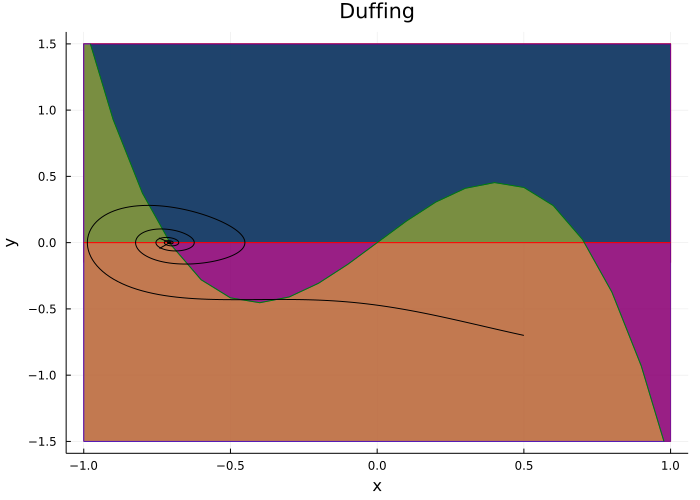

In [31]:
#la Ed para el oscilador de Duffing definida in-place
function duffing!(du,u,p,t)
    du[1] = u[2]
    du[2] = -p[1]*u[2]+u[1]*(p[2]-u[1]*u[1])
    du
end    

# Esto es interactivo en ipynb
#xini=0.5;yini=-0.7;γ=0.3;β=0.5
@manipulate for xini=-1:0.02:1,yini=-1.5:0.2:1.5,γ=0.0:0.01:2.0,β=-0.5:0.1:0.5
    flux2d_nullclines(duffing!,[xini;yini],50.0,[γ,β];ylims=[-1.5,1.5],title="Duffing")
end    

### Deteccion de la Pitchfork usando BifurcationKit

Vamos a usar BifurcationKit para barrer esta bifurcación. A diferencia del caso anterior esta bifurcación no tiene una sola rama (se considera la SN una sola rama que "pega la vuelta" en la bifurcacion). Por ello tenemos que detectar dos ramas y eso lo podemos hacer solo para valores de $\beta$ positivo donde tengo tres puntos fijos. 

La estrategia es utilizar dos puntos iniciales diferentes como guess del punto fijo, uno muy cerca de cero para el punto silla y otro en un valor grande para tender hacia el atractor (tener en cuenta que el algoritmo detecta puntos fijos de cualquier tipo por lo tanto es irrelevante que sea un atracto un punto silla o un repulsor pero si tiene que estar cerca)

Notar que en este caso estamos barriendo el segundo parámetro, de allí `@lens _[2]` y que tambien tenemos que barrer hacia los negativos en la rama parabolica (br1). En la otra rama (br1) da igual porque existe para valores positivos y negativos de $\beta$.

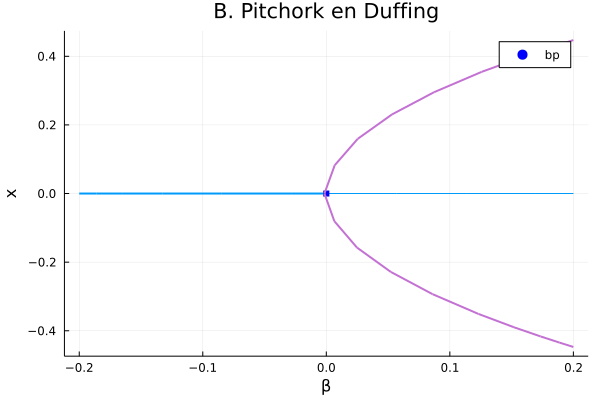

In [27]:
duffing(u,p) = duffing!(similar(u),u,p,0)
opts = ContinuationPar(pMin=-0.2,pMax=0.2, ds = 0.01, dsmax = 0.04,detectBifurcation=3,nInversion=8)
br1, = continuation(duffing,[0.1,0.1],[0.1,-0.2],(@lens _[2]), opts)
opts = ContinuationPar(pMin=-0.2,pMax=0.2, ds=-0.01, dsmax=0.04, detectBifurcation=3)
br2, = continuation(duffing,[-0.5,0.1],[0.1,0.2],(@lens _[2]), opts;recordFromSolution = (x, p) -> x[1])
plot(br1)
plot!(br2,xlabel="\\beta",title="B. Pitchork en Duffing",fmt=:png)

# Bifurcacion de Hopf

En Flujos 2D existe otra bifurcacion que no existe en 1D. Cuando un punto fijo pierde estabilidad, pasa de ser atractor a repulsor lo hace a traves de un centro (foco atractor que se transforma en repulsor). Esto sucede cuando el Determinante del Jacobiano es positivo y la Traza cambia de signo pasando por cero. Recordar que en este caso los autovalores eran complejos (foco) y la parte real era la traza asi que otra forma de caracterizar esta bifurcacion es cuando para un punto fijo **ambos** autovalores cruzan el eje imaginario (parte real cero). 

En un sistema lineal eso significa unicamente un cambio de direccion en el flujo del foco (espiral atractor a repulsor). Pero en los sistemas no lineales los terminos de orden mas alto dan de forma generica origen a un ciclo limite que es expelido del foco y se produce una **Bifurcacion de Hopf** con el cambio de estabilidad. 

Hay dos tipos de Bifurcación de Hopf, **supercritica** y **subcritica**. Por ahora nos va a interesar mas la supercritica y para este tipo la historia es asi: de un lado de la bifurcacion (en la figura para $\beta<0$) tenemos un foco atractor, el Jacobiano tiene traza negativa. En la bifurcacion el foco se transforma en un centro ($\beta=0$) y las trayectorias se siguen aproximando (por los terminos no lineales) pero no convergen nunca al centro. Y luego de la bifurcacion el punto fijo pierde estabilidad y se transforma en repulsor. 

Pero ahora bien, como es una bifurcacion LOCAL el flujo lejos "no se entera" del cambio de estabilidad y sigue siendo atractor (dominan los terminos no lineales). Por lo tanto el flujo sigue siendo globalmente atractor y se acerca a la región del centro. Pero como al mismo tiempo es expelido de el por el foco repulsor, en alguna parte se tiene que acumular el flujo y se forma un ciclo limite estable. Es decir que del otro lado de la bifurcacion (para $\beta>0$) tengo un foco repulsor que alimenta a un ciclo limite atractor.

<div>
<img src="../files/hopf.png" width="500px">
</div>

La forma normal de la bifurcacion de Hopf (supercritica) es la siguiente


$\dot{x} = \beta x - \omega y - x(x^2+y^2)$

$\dot{y} = \omega x + \beta y - y(x^2+y^2)$

Parece complicado pero veamos primero que el punto fijo esta en $(0,0)$ y si queremos calcular el Jacobiano va a tener un monton de terminos pero solo van a sobrevivir los que no tengan ni $x$ ni $y$ porque esos van a ser cero. Asi que el Jacobiano evaluado en el punto fijo $(0,0)$ es solo el de la parte lineal y es:

$\begin{pmatrix}\beta & -\omega\\\omega & \beta \end{pmatrix}$

La traza es $2\beta$ y el determinante siempre positivo $\beta^2+\omega^2$. Por lo tanto cuando $\beta$ cruza el cero cambia el signo de la Traza y el foco pasa de ser atractor a repulsor como muestra la figura.

Por otro lado los terminos no lineales tienen una expresion que equivale al radio al cuadrado $(x^2+y^2)$ con la variable cambiada de signo por lo tanto siempre van a ser atractores lejos. 

In [12]:
function hopf!(du,u,p,t)
    (β,ω) = p
    du[1] = β*u[1] - ω*u[2] - u[1]*(u[1]*u[1]+u[2]*u[2])
    du[2] = ω*u[1] + β*u[2] - u[2]*(u[1]*u[1]+u[2]*u[2])
    du
end

hopf! (generic function with 1 method)

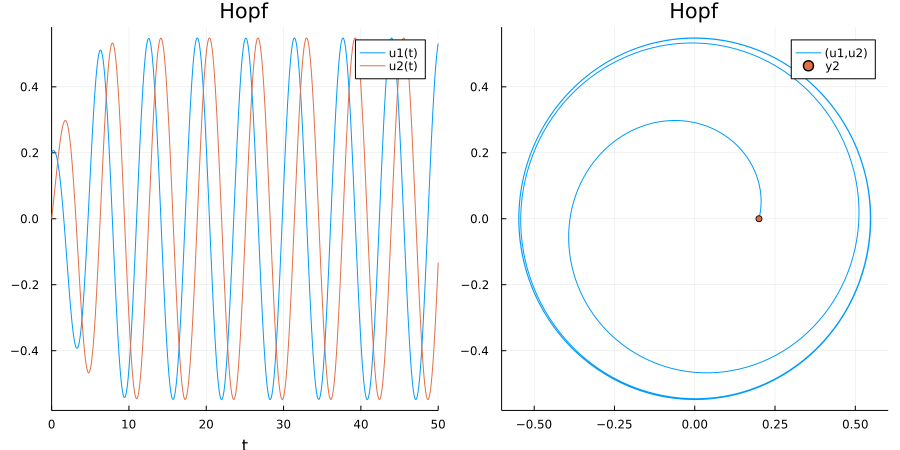

In [32]:
# Esto es interactivo en ipynb
#xini=0.2;yini=0.0;tmax=50.0;ω=1.0;β=0.3
@manipulate throttle=.05 for xini=-1:0.1:1,yini=-1:0.1:1,tmax=10:10:50,ω=0.1:0.1:1,β=-0.5:.02:0.5
    prob = ODEProblem(hopf!, [xini; yini], (0, tmax), [β,ω])
    sol = solve(prob);
    p1 = plot(sol)
    p2 = plot(sol,vars=(1,2))
    scatter!(p2,[prob.u0[1]],[prob.u0[2]])
    plot(p1,p2,layout=(1,2),size=(900,450),title="Hopf",fmt=:png)
end

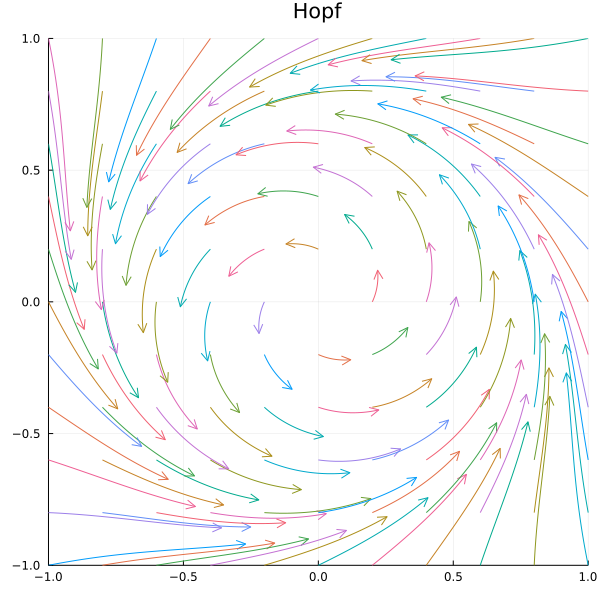

In [14]:
# multiples trayectorias
u0_arr = vec([[0.2*i-1,0.2*j-1] for i=0:10, j=0:10])
prob = ODEProblem(hopf!,u0_arr[1],(0,0.5),[0.5,1.0])
ensamble_prob = EnsembleProblem(prob,prob_func=(prob,i,repeat;u0=u0_arr)->(remake(prob,u0=u0[i])))
sol = solve(ensamble_prob,EnsembleThreads(),trajectories=length(u0_arr))
plot(sol,vars=(1,2),arrow=true,size=(600,600),title="Hopf",fmt=:png)

### Deteccion de la Hopf usando BifurcationKit

Vamos a usar BifurcationKit para detectar esta bifurcación. Este caso es relativamente sencillo, ya que el punto fijo existe a ambos lados de la bifurcación y tenemos una sola rama. Notar que, a diferencia de los casos anteriores en los que marcaba los puntos de bifurcación en el diagrama unicamente como "bp" (bifurcation point), ahora llevan la etiqueta de una Hopf.

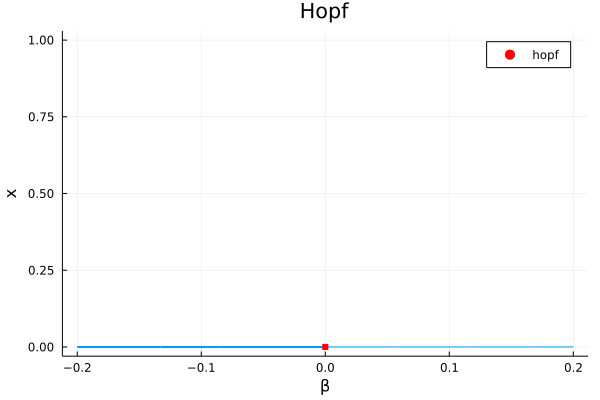

In [16]:
hopf(u,p) = hopf!(similar(u),u,p,0)
opts = ContinuationPar(pMin=-0.2,pMax=0.2, ds = 0.01, dsmax = 0.04,detectBifurcation=3,nInversion=8)
br1, = continuation(hopf,[0.1,0.1],[-0.2,1.0],(@lens _[1]), opts)
plot(br1,xlabel="\\beta",title="Hopf",fmt=:png)

## Forma normal de la Hopf en polares 

Podemos reescribir la forma normal de Hopf como:

$\begin{pmatrix}\dot{x}\\\dot{y}\end{pmatrix}=\begin{pmatrix}\beta & -\omega\\ \omega & \beta\end{pmatrix}\begin{pmatrix}x\\y\end{pmatrix}-(x^2+y^2)\begin{pmatrix}x\\y\end{pmatrix}$ 


Vamos a cambiar ahora a coordenadas polares:

$\rho = \sqrt{x^2+y^2}, \quad \theta=\arctan\left({\displaystyle\frac{y}{x}}\right)$

con la transformación inversa:

$x = \rho \cos{(\theta)},\quad y = \rho \sin{(\theta)}$

Luego de operar algebraicamente y usando extensivamente la relación $\cos^2{(\theta)}+\sin^2{(\theta)}=1$ llegamos a un sistema mucho más simple en coordenadas polares:

$\dot{\rho} = \beta\rho - \rho^3$

$\dot{\theta} = \omega$

que es la forma normal de la bifurcación de Hopf en coordenadas polares. 

Lo notable es que la segunda ecuación (la variación angular) es invariante y lo único que indica es que el flujo gira en torno al origen con velocidad angular constante $\omega$ (algo que se puede verificar en el flujo). Mientras que la primera ecuación para la variación en el radio tiene la misma forma que la bifurcación de pitchfork en 1D! Si bien hay que tener en cuenta que por definición $\rho \geq 0$.

Por lo tanto, al igual que en la pitchfork supercrítica vamos a tener, para $\beta<0$ un atractor en el origen en la dirección radial (que junto con la variación angular a velocidad constante dan lugar a una espiral atractora), mientras que para 
$\beta>0$ el punto fijo en $\rho=0$ se vuelve repulsor y aparece un punto fijo atractor en $\rho=\sqrt{\beta}$ que corresponde a un ciclo límite atractor con radio constante. 

El diagrama de bifurcaciones en la coordenada radial quedaría entonces para la Hopf (atencion que lo hacemos a mano y no usando BifurcationKit) :

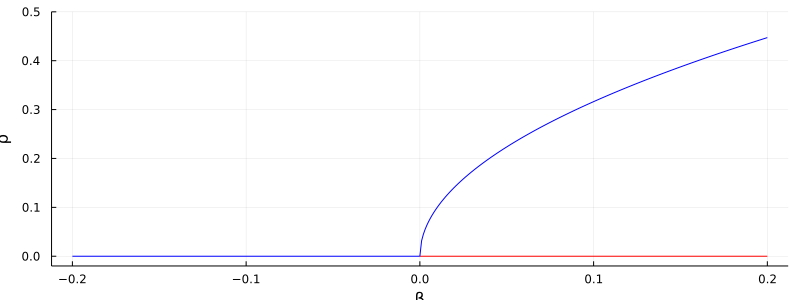

In [17]:
βneg = -0.2:0.001:0.0; βpos = 0.0:0.001:0.2
ρ2 = sqrt.(βpos)
plot(βneg,0*βneg,c=:blue,legend=false)
plot!(βpos,0*βpos,c=:red)
plot!(βpos,ρ2,c=:blue,ylims=(-0.02,0.5),xlabel="\\beta",ylabel="\\rho",size=(800,300),fmt=:png)

### Amplitud de la oscilación de Hopf 

Recordamos que habiamos definido el diagrama de bifurcaciones en el espacio producto del (o los) parámetro(s) y las variables y graficábamos los conjuntos límite (hasta ahora puntos fijos) como ramas (curvas) coloréandolos según su estabilidad. 

En el caso de la Hopf, al tratarse de una bifurcación que involucra si o si dos variables (no tenemos como en el caso de la SN la relajación a una variedad unidimensional porque la variedad sobre la que ocurre la Hopf tiene que ser bidimensional), nuestro diagrama de bifurcaciones tendría que ser 3D, graficando los conjuntos límite en el espacio de fases $(x,y)$ en función de nuestro parámetro de bifurcación $\beta$.

Afortunadamente en el caso de la forma normal de Hopf es muy sencillo porque en coordenadas polares ya tenemos el diagrama de bifurcaciones en la variable radial y la variable angular lo único que hace es rotar el diagrama anterior en torno al origen. Como resultado, la rama estable de $\rho=\sqrt{\beta}$ determina un ciclo límite atractor cuya amplitud crece con la raíz cuadrada del parámetro y cuya velocidad angular ($\dot{\theta}$) es exactamente igual a 1:

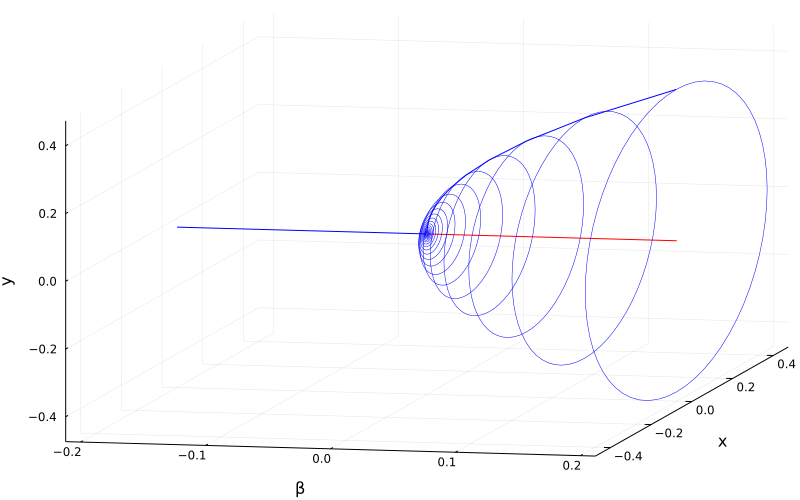

In [18]:
θlist = 0:π/30:2*π
βlist = 10 .^(-4.7:0.2:-0.7)
p1 = plot(βneg,0*βneg,0*βneg,c=:blue,legend=false)
plot!(p1,βpos,0*βpos,0*βneg,c=:red)
plot!(p1,βlist,0*βlist,sqrt.(βlist),c=:blue)
for β in βlist
    ρ = sqrt(β)
    plot!(p1,β.+0*θlist,ρ*cos.(θlist),ρ*sin.(θlist),c=:blue,linewidth=0.5)
end    
plot(p1;xlabel="\\beta",ylabel="x",zlabel="y",size=(800,500),camera=(20,35),fmt=:png)

### Frecuencia de la oscilación de Hopf

Volviendo a la forma normal de la Hopf:

$\begin{pmatrix}\dot{x}\\\dot{y}\end{pmatrix}=\begin{pmatrix}\beta & -\omega\\\omega & \beta\end{pmatrix}\begin{pmatrix}x\\y\end{pmatrix}-(x^2+y^2)\begin{pmatrix}x\\y\end{pmatrix}$ 

Si calculamos los autovalores de la parte lineal resulta que en la bifurcación $\omega$ corresponde a la parte imaginaria del autovalor y $\beta$ es la parte real que se anula. En efecto de la matiz lineal tenemos que el determinante es $\Delta=\beta^2+\omega^2$ y la traza es $\tau=2\beta$, por lo tanto:

$\lambda_{\pm} = \frac{\tau\pm\sqrt{\tau^2-4\Delta}}{2} = \beta \pm\sqrt{-\omega^2}=\beta \pm i\omega$

En la bifurcación $\beta=0$ y los autovalores son puramente imaginarios

$\lambda_{\pm} = \pm i\omega$

Cuando pasamos a coordenadas polares resulta evidente el rol que cumple $\omega$:

$\dot{\rho} = \beta\rho - \rho^3$

$\dot{\theta} = \omega$

es decir que es precisamente la frecuencia angular del ciclo límite que surge en la Hopf.



Es importante notar que esta separación de variables puede hacerse para la forma normal pero no de forma general. Sin embargo, al igual que con el resto de las bifurcaciones, **todo sistema genérico que anule la parte real de un par de autovalores conjugados es topológicamente equivalente a la forma normal de la Hopf**, por lo tanto para esos sistemas también tendremos el nacimiento de un **ciclo límite que aparece con amplitud proporcional a la raíz cuadrada del parámetro de bifurcación y con una frecuencia de oscilación aproximada por la parte imaginaria del autovalor**.

### Transformacion de polares a cartesianas

Cuando pasamos la forma de la Hopf a polares evitamos los pasos intermedios porque son bastante engorrosos. Sin embargo ir en el sentido inverso es bastante sencillo y nos va a servir luego para estudiar modelos simples de bifurcaciones de ciclos limites. Supongamos que partimos de un sistema escrito en coordenadas polares especificando ($\dot{\rho},\dot{\theta}$). Como pasar a las ecuaciones diferenciales escritas en cartesianas ($\dot{x},\dot{y}$)?
Partimos de:

$x = \rho \cos{(\theta)},\\ x = \rho \sin{(\theta)}$

Tenemos que derivar estas expresiones respecto al tiempo (usando la regla de la cadena y la derivada del producto:

$\dot{x} = \dot{\rho} \cos{(\theta)} - \rho \sin{(\theta)} \dot{\theta} = \displaystyle\frac{\dot{\rho}x}{\rho} - \displaystyle\frac{\rho\dot{\theta}y}{\rho}$

$\dot{y} = \dot{\rho} \sin{(\theta)} + \rho \cos{(\theta)} \dot{\theta} = \displaystyle\frac{\dot{\rho}y}{\rho} + \displaystyle\frac{\rho\dot{\theta}x}{\rho}$

donde en el ultimo paso usamos la conversion de variables para sacarnos de encima los senos y cosenos. 
Vamos a suponer ahora por simplicidad que la dinámica ocurre solo en la variable radial y que $\dot{\theta}=\omega$
De esta forma nuestro sistema de ecuaciones queda expresado de una forma bastante elegante como:

$\dot{x} = -\omega y + x \left(\dot{\rho}/\rho\right)$

$\dot{y} = \omega x + y \left(\dot{\rho}/\rho\right)$

Dependiendo de la elección de $\dot{\rho}$ vamos a tener diferentes dinámicas y eso se va a poder trasladar fácil a un sistema ($\dot{x},\dot{y}$). Por ejemplo si reemplazamos $\dot{\rho} = \beta\rho - \rho^3$:

$\dot{x} = -\omega y + \beta x - x \rho^2$

$\dot{y} = \omega x + \beta y  - y \rho^2$

que es la expresión original de la Hopf ($\rho^2=x^2+y^2$).

Como ejemplo simple podemos usar $\dot{\rho} = \beta\rho + \rho^3$ que corresponde a la bifurcación de Pitchfork **subritica** en el que se crean puntos fijos para $\beta<0$ y son inestables. Si reemplazamos obtenemos:

$\dot{x} = -\omega y + \beta x + x \rho^2$

$\dot{y} = \omega x + \beta y  + y \rho^2$

donde lo unico que cambio es el signo del término no lineal y corresponde a la forma normal de una bifurcación de **Hopf subcritica** donde el ciclo límite es creado para $\beta<0$, es repulsor y convive con un foco atractor, con el cual colapsa a $\beta=0$ convirtiéndolo en un foco repulsor.

## Ejemplos simples de bifurcaciones de Hopf

### Lengüeta de Rayleigh
Como un ejemplo simple consideremos el modelo de Rayleigh de la lengüeta:


$\dot{x} = y$

$\dot{y} = \mu y-y^3-kx$


con un único punto fijo en el origen. El Jacobiano de forma general es:

$\begin{pmatrix}0 & 1\\-k & \mu-3y^2 \end{pmatrix}$

evaluado en el punto fijo $x=0$, $y=0$ es 

$\begin{pmatrix}0 & 1\\-k & \mu \end{pmatrix}$

que tiene determinante siempre positivo $\Delta=k$ y la traza igual al parámetro $\mu$. El punto fijo es atractor para $\mu<0$ y repulsor para $\mu>0$. Cuando $\mu=0$ la traza se anula y los autovalores son puramente imaginarios:

$\lambda_1 = \frac{\tau\pm\sqrt{\tau^2-4\Delta}}{2} = \pm\frac{\sqrt{-4k}}{2}  = \pm i\sqrt{k}$

Tenemos una bifurcación de Hopf y encontramos la relación entre el parámetro de elasticidad $k$ y la frecuencia de oscilación en la bifurcación: $k=\omega^2$ al igual que en el oscilador armónico. Sabemos además que la amplitud de las oscilaciones va a crecer de forma suave al principio como $\sqrt{\mu}$ 

### van der Pol sesgado

Hay una condición más para que se produzca la bifurcación de Hopf y es que en la bifurcación persistan términos no lineales (en realidad están vinculados con la segunda derivada del campo vector pero no vamos a entrar en ese detalle técnico). 

Por ese motivo en el oscilador de van der Pol no tenemos una bifurcación de Hopf, si bien cuando $\mu=0$ los autovalores tienen parte real cero, ya que para este valor de parámetro también se anula el único no lineal $-\mu x^2y$. Como consecuencia, no hay ciclos límites "pequeños" cerca de la bifurcación sino que el ciclo límite ya nace "grande" como una oscilación de relajación. 

Sin embargo, basta con perturbar el sistema con una variable constante (lo que se conoce como sistema de van der Pol sesgado) y tenemos una bifurcación de Hopf:

$\dot{x} = y$

$\dot{y} = \mu (1 -x^2)y - x  + a$

Este sesgo corre el punto fijo del origen al punto $(x_*,y_*)=(a,0)$. Notar que este corrimiento no es un mero cambio de coordenadas porque afecta al flujo global. Esto último se puede probar con un cambio de coordenadas llevando el punto fijo al origen (definiendo una nueva variable $x_1=x-a$) y viendo que aparecen otros términos no lineales y que la dependencia con la perturbación $a$ queda incorporada en el parámetro para el cual se produce la bifurcación. Pero vamos a ver lo mismo en el sistema escrito ahi arriba de forma más simple. La matriz Jacobiana queda de forma general:

$\begin{pmatrix}0 & 1\\-1-2\mu xy & \mu (1-x^2)\end{pmatrix}$

que evaluada con $x=a$ y $y=0$ resulta en la matriz de linealización en un entorno del punto fijo:

$\begin{pmatrix}0 & 1\\-1 & \mu (1-a^2)\end{pmatrix}$

Como en el caso anterior el determinante es siempre positivo $\Delta=1$ pero la traza incluye a ambos parámetros $\mu(1-a^2)$. Entonces haciendo $\mu \neq 0$ evadimos la degeneración del van der Pol original y obtenemos una bifurcación de Hopf cuando $a$ cruza el valor 1 o -1. 

Esto se puede explorar en el gráfico interactivo de abajo


In [19]:
function vdp_biased!(du,u,p,t)
    (μ,a) = p
    du[1] = u[2]
    du[2] = μ*(1.0-u[1]*u[1])*u[2]-u[1]+a
    du
end   

vdp_biased! (generic function with 1 method)

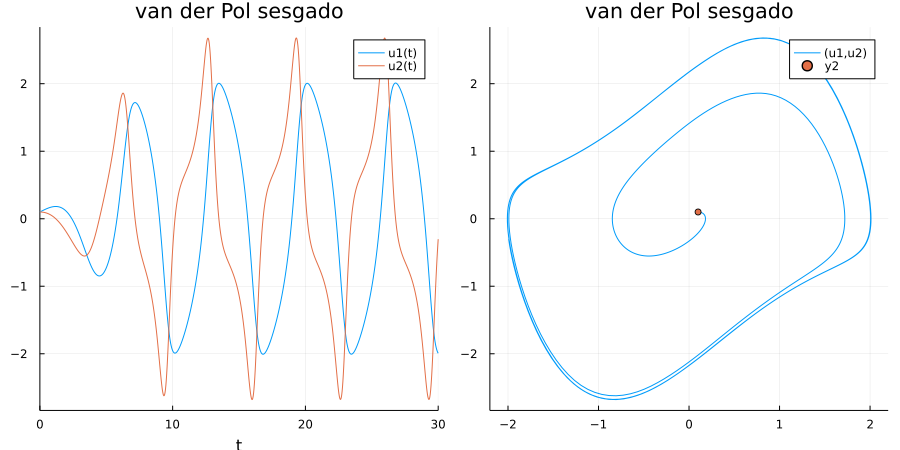

In [33]:
# Esto es interactivo en ipynb
#xini=0.1;yini=0.1;tmax=30.0;a=0;
@manipulate throttle=.05 for xini=-1:0.1:1,yini=-1:0.1:1,tmax=10:10:50,a=-1.5:0.01:1.5
    prob = ODEProblem(vdp_biased!, [xini; yini], (0, tmax), [1.0,a])
    sol = solve(prob);
    p1 = plot(sol)
    p2 = plot(sol,vars=(1,2))
    scatter!(p2,[prob.u0[1]],[prob.u0[2]])
    plot(p1,p2,layout=(1,2),size=(900,450),title="van der Pol sesgado",fmt=:png)
end